In [1]:
# General
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil

# pysynphot - work with spectra
import pysynphot as S

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"

hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

x_pos = 2124
y_pos = 1223
size = 500
cutout_condition = (abs(hlss_tbl["X_IMAGE"] - x_pos) < size) & (abs(hlss_tbl["Y_IMAGE"] - y_pos) < size)
cutout_tbl = hlss_tbl[np.where(cutout_condition)]

In [3]:
# Generate & save empty placeholder seg map
data = np.zeros((4088,4088))

# Take header info from prepared direct image
file = fits.open(direct_file)
hdr = file[1].header
file.close()

fits.writeto(empty_seg, data=data, header=hdr, overwrite=True)

del data
del hdr

In [4]:
# Prepare shape-defining equations
# GALAXY ellipses
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x,y,x_0,y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)

# STAR circle
gen_cirl = lambda x,y,x_0,y_0: (x-x_0)**2 + (y-y_0)**2

star_radius = lambda mag: 4663 * 10**(-0.1587 * mag) + 1.596 # + 1.596 # Roughly sketched in logger pro then doubled

In [5]:
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [6]:
mag = 17.5
x_0 = 300
y_0 = 600

radius = star_radius(mag)
circ = lambda x, y: gen_cirl(x, y, x_0, y_0)

# Create meshgrid cutout
x_min = max(0, int(x_0 - radius + 1)) # floor
x_max = min(4087, int(x_0 + radius + 1) + 1) # ceil
y_min = max(0, int(y_0 - radius + 1))
y_max = min(4087, int(y_0 + radius + 1) + 1)
x_cutout = np.arange(x_min, x_max)
y_cutout = np.arange(y_min, y_max)
x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

condition = circ(x_grid, y_grid) <= radius

def func(i,j):
    print("i:", i)
    print("j:", j)
    return 0

np.fromfunction(func, shape=(2, 2))

i: [[0. 0.]
 [1. 1.]]
j: [[0. 1.]
 [0. 1.]]


0

In [7]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

error_file = open("errors.txt", "a+")

for object in tqdm(cutout_tbl):
    
    # SEGMENTATION -------------------------------

    temp_seg = np.zeros((4088,4088))

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]
    modimage = object["MODIMAGE"]

    # STAR
    if modimage:
        radius = star_radius(mag)
        circ = lambda x, y: gen_cirl(x, y, x_0, y_0)

        # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1)) # floor
        x_max = min(4087, int(x_0 + radius + 1) + 1) # ceil
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4087, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        condition = circ(x_grid, y_grid) <= radius

    # GALAXY
    else:
        a = object["A_IMAGE"]
        b = object["B_IMAGE"]
        theta = object["THETA_IMAGE"]
        radius = 3

      # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1))
        x_max = min(4087, int(x_0 + radius + 1) + 1)
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4087, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        ellipse = lambda x,y: gen_ellipse(x, y, x_0, y_0, (theta, a, b))
        condition = ellipse(x_grid, y_grid) <= radius

    temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id 

    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue
    roman_sim.seg = np.rot90(temp_seg,k=3).astype("float32")

    # SIMULATION ---------------------------------

    # STAR
    if object["MODIMAGE"]:
        sed_path = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/ukg0v.fits"
        file = fits.open(sed_path)
        wave = np.linspace(10000,20000,2000)
        flux = file[0].data[1770:3770]
        file.close()
        z = 0

    # GALAXY
    else:
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

    spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
    spec = spec.renorm(mag, "abmag", bp)
    spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

100%|██████████| 681/681 [00:51<00:00, 13.12it/s]


In [8]:
sim_min = roman_sim.model.min()
sim_max = roman_sim.model.max()
sim_median = np.median(roman_sim.model[723:1723, 1624:2624])

print(f"min: {sim_min}", f"max: {sim_max}", f"median: {sim_median}", sep='\n')

min: 0.0
max: 53.289920806884766
median: 0.0


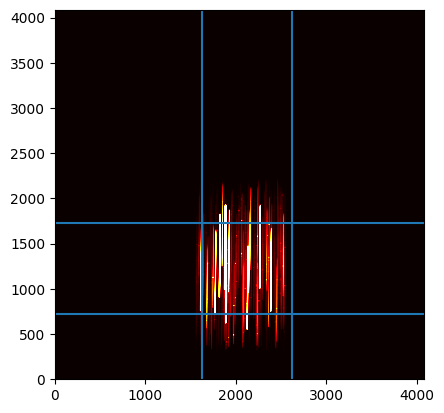

In [9]:
fig, ax = plt.subplots()

upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
ax.imshow(upright_img, origin='lower', vmin=0, vmax=0.11738539732765789, cmap='hot')



ax.axvline(1624)
ax.axvline(2624)
ax.axhline(723)
ax.axhline(1723)